In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import itertools




In [2]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name='filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis=1)

def create_df(dir):
    files, classes = define_paths(dir)
    return define_df(files, classes)



In [3]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (32, 32)  # Adjusted for LeNet-5
    channels = 1  # LeNet-5 expects grayscale images
    def preprocess(img):
        return img  # No special preprocessing
    tr_gen = ImageDataGenerator(preprocessing_function=preprocess)
    ts_gen = ImageDataGenerator(preprocessing_function=preprocess)
    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                           target_size=img_size, class_mode='categorical',
                                           color_mode='grayscale', batch_size=batch_size, shuffle=True)
    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels',
                                           target_size=img_size, class_mode='categorical',
                                           color_mode='grayscale', batch_size=batch_size, shuffle=True)
    test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                          target_size=img_size, class_mode='categorical',
                                          color_mode='grayscale', batch_size=batch_size, shuffle=False)
    return train_gen, valid_gen, test_gen

dir = 'DATASET/'
df = create_df(dir)
train_df, test_valid_df = train_test_split(df, test_size=0.2, random_state=42)
test_df, valid_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)

batch_size = 32
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)



Found 1386 validated image filenames belonging to 3 classes.
Found 174 validated image filenames belonging to 3 classes.
Found 172 validated image filenames belonging to 3 classes.


F:\SOFTWARE\ANACONDA\envs\face\lib\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 2 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '
F:\SOFTWARE\ANACONDA\envs\face\lib\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


In [4]:
# Define LeNet-5 model
model = Sequential([
    Conv2D(6, kernel_size=(5, 5), activation='tanh', input_shape=(32, 32, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size=(5, 5), activation='tanh'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(120, activation='tanh'),
    Dense(84, activation='tanh'),
    Dense(len(train_gen.class_indices), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

filepath = 'lenet5_model.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', save_best_only=True, mode='max')

history = model.fit(train_gen, epochs=100, validation_data=valid_gen, callbacks=[checkpoint])



Epoch 1/100
44/44 [==============================] - 18s 399ms/step - loss: 1.0761 - accuracy: 0.4286 - val_loss: 0.9916 - val_accuracy: 0.4828
Epoch 2/100
44/44 [==============================] - 6s 137ms/step - loss: 0.8917 - accuracy: 0.5613 - val_loss: 0.8801 - val_accuracy: 0.6264
Epoch 3/100
44/44 [==============================] - 6s 136ms/step - loss: 0.7745 - accuracy: 0.6465 - val_loss: 0.8334 - val_accuracy: 0.6149
Epoch 4/100
44/44 [==============================] - 6s 137ms/step - loss: 0.6903 - accuracy: 0.6962 - val_loss: 0.8495 - val_accuracy: 0.5747
Epoch 5/100
44/44 [==============================] - 6s 137ms/step - loss: 0.6007 - accuracy: 0.7244 - val_loss: 0.6823 - val_accuracy: 0.7299
Epoch 6/100
44/44 [==============================] - 6s 139ms/step - loss: 0.5044 - accuracy: 0.7785 - val_loss: 0.6047 - val_accuracy: 0.7701
Epoch 7/100
44/44 [==============================] - 6s 140ms/step - loss: 0.4187 - accuracy: 0.8276 - val_loss: 0.4967 - val_accuracy: 0.833

In [5]:
# Load best model
model = keras.models.load_model(filepath)
train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)

print("Train Accuracy:", train_score[1])
print("Validation Accuracy:", valid_score[1])
print("Test Accuracy:", test_score[1])



6/6 [==============================] - 2s 359ms/step - loss: 0.1119 - accuracy: 0.9884
Train Accuracy: 0.9942280054092407
Validation Accuracy: 0.9655172228813171
Test Accuracy: 0.9883720874786377


6/6 [==============================] - 1s 119ms/step


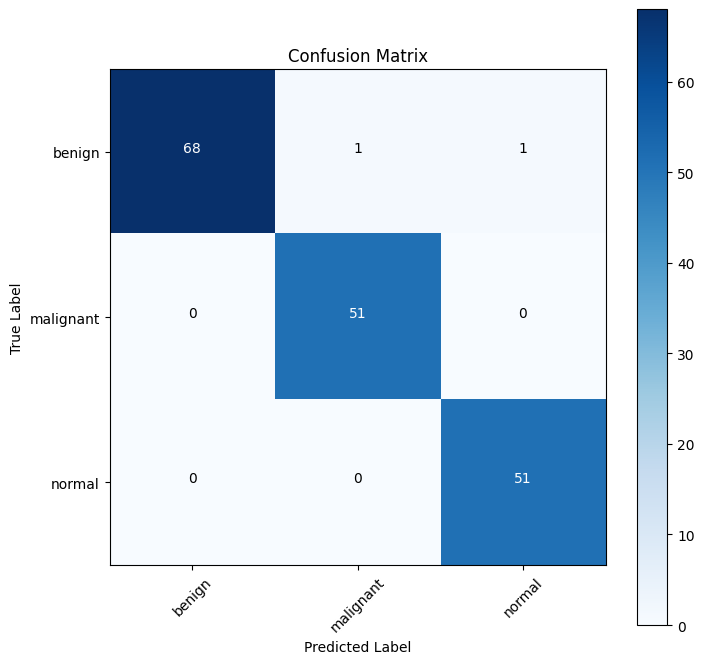

              precision    recall  f1-score   support

      benign       1.00      0.97      0.99        70
   malignant       0.98      1.00      0.99        51
      normal       0.98      1.00      0.99        51

    accuracy                           0.99       172
   macro avg       0.99      0.99      0.99       172
weighted avg       0.99      0.99      0.99       172



In [6]:
# Predictions and Confusion Matrix
y_pred = np.argmax(model.predict(test_gen), axis=1)
cm = confusion_matrix(test_gen.classes, y_pred)

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > cm.max()/2 else 'black')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm, list(train_gen.class_indices.keys()))
print(classification_report(test_gen.classes, y_pred, target_names=list(train_gen.class_indices.keys())))